# Hyperparameters and Model Validation

# A. Model Validation:

* Model Validation 
    * After choosing a model and its hyperparameters, we can estimate how effective it is by applying it to some of the training data and comparing the predictions to the known values.

### A.1. Model Validation: The Wrong Way:

* Training and evaluating the model on the same data.

In [1]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

model = KNeighborsClassifier(n_neighbors=1)
model.fit(X, y)
y_model = model.predict(X)

accuracy_score(y, y_model)

1.0

### A.2. Model Validation: The Right Way: Holdout Sets

* Holdout set:
    * hold back some subset of the data from the training of the model, and then use this holdout set to check the model's performance.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.7)

In [4]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

0.9777777777777777

### A.3. Model Validation via Cross-Validation:

* One disadvantage of using a holdout set for model validation is that we have lost a portion of our data to the model training.
    * Cross-validation :
        * Do sequence of fits where each subset of data is used both as training set and as a validation set.

        * 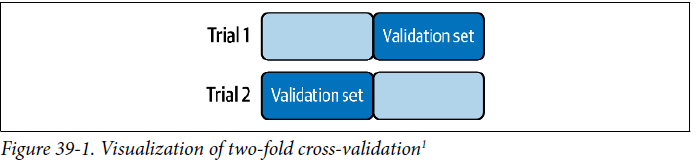
        * 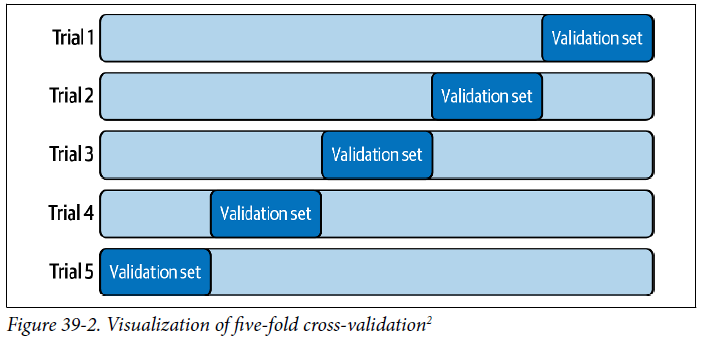

    * Leave-one-out cross validation:
        * Number of folds is equal to the number of data points.
        * We train on all points but one in each trial.

In [5]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

In [6]:
from sklearn.model_selection import LeaveOneOut

scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores.shape

(150,)

In [7]:
scores.mean()

0.96

# B. Selecting the Best Model

* If our estimator is underperforming, how should we move forward?
    * Use a more complicated/more flexible model.
    * Use a less complicated/less flexible model.
    * Gather more training samples.
    * Gather more data to add features to each sample.

### B.1. The Bias-Variance Trade-off

* Fundamentally, finding “the best model” is about finding a sweet spot in the trade-off between bias and variance.
* High Bias Model:
    * Such a model is said to underfit the data:
        * It does not have enough flexibility to suitably account for all the features in the data.
    * The performance of the model on the validation set is similar to the performance of the training set.


* High Variance Model:
    * Such a model is said to overfit the data:
        * it has so much flexibility that the model ends up accounting for random errors as well as the underlying data distribution.
    * THe performance of the model on the validation set is far worse than the performance on the training set.

* If we imagine that we have some ability to tune the model complexity, we would expect the training score and validation score to behave as the ff:
    * The training score is everywhere higher than the validation score. This is generally the case: the model will be a better fit to data it has seen than to data it has not seen.
    * For very low model complexity (a high-bias model), the training data is underfit, which means that the model is a poor predictor both for the training data and for any previously unseen data.
    * For very high model complexity (a high-variance model), the training data is overfit, which means that the model predicts the training data very well, but fails for any previously unseen data.
    * For some intermediate value, the validation curve has a maximum. This level of complexity indicates a suitable trade-off between bias and variance.

    * 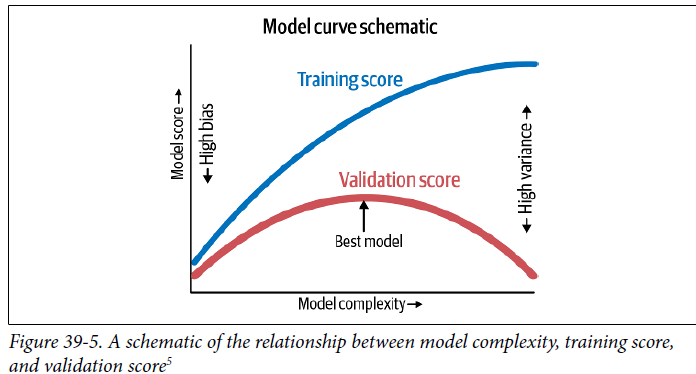

### B.2. Validation Curves in Scikit-learn:

* Example:
    * What degree of polynomial provides a suitable trade-off between bias (underfitting) and variance (overfitting)?

In [12]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

C:\Users\JCA\AppData\Local\Temp\ipykernel_18756\3150204418.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [14]:
def make_data(N, err=1.0, rseed=1):
    #randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1)**2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y


def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

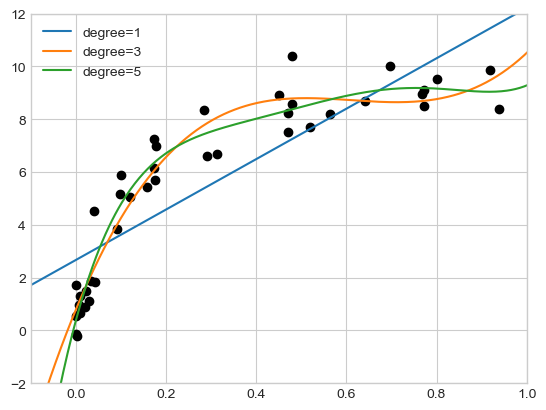

In [15]:
X, y = make_data(40)
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()

for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))

plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');


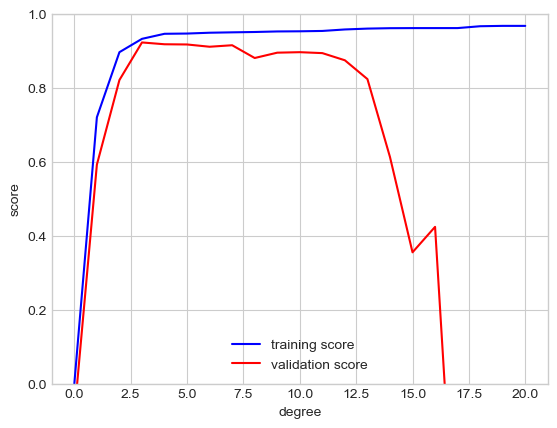

In [16]:
# Using validation_curve submodule

from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(
                            PolynomialRegression(), X, y,
                            param_name='polynomialfeatures__degree',
                            param_range=degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

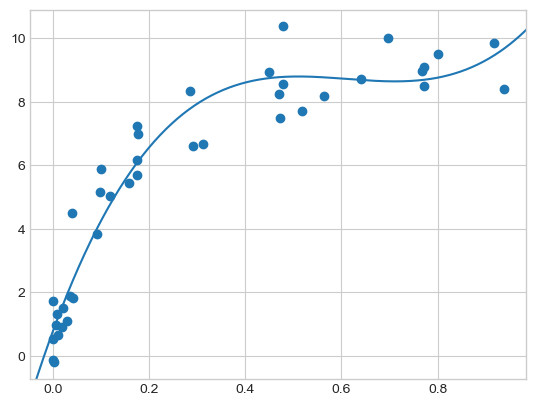

In [17]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

# C. Learning Curves

* One important aspect of model complexity is that the optimal model will generally depend on the size of your training data.
* The behavior of the validation curve has 2 important inputs:
    * Model Complexity
    * Number of training points

* Learning Curves:
    * A plot of the training/validation score w/ respect to the size of the training set.

* The general behavior we would expect from a learning curve is this:
    * A model of a given complexity will overfit a small dataset: this means the training score will be relatively high, while the validation score will be relatively low.
    * A model of a given complexity will underfit a large dataset: this means that the training score will decrease, but the validation score will increase.
    * A model will never, except by chance, give a better score to the validation set than the training set: this means the curves should keep getting closer together but never cross.

    * 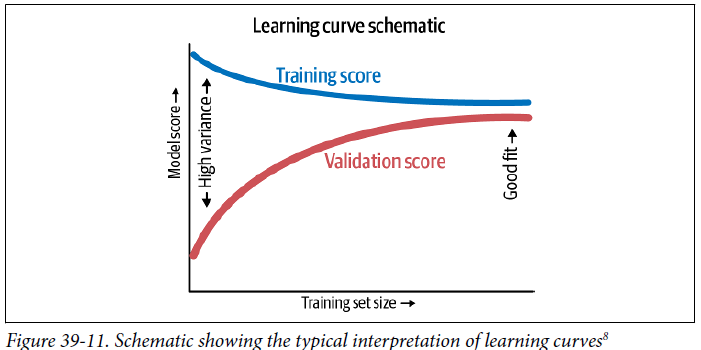

* In particular, once you have enough points that a particular model has converged, adding more training data will not help you>
    * The only way to increase model performance in this case is to use another (often more complex) model.

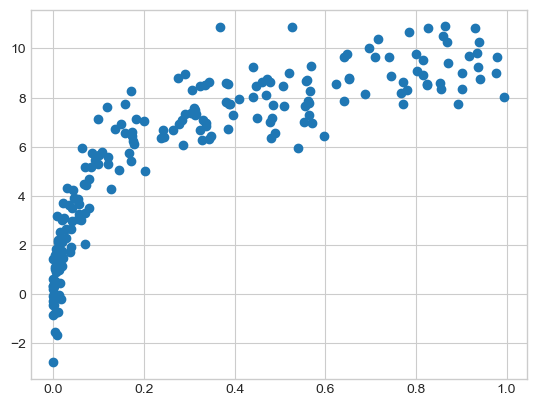

In [20]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);


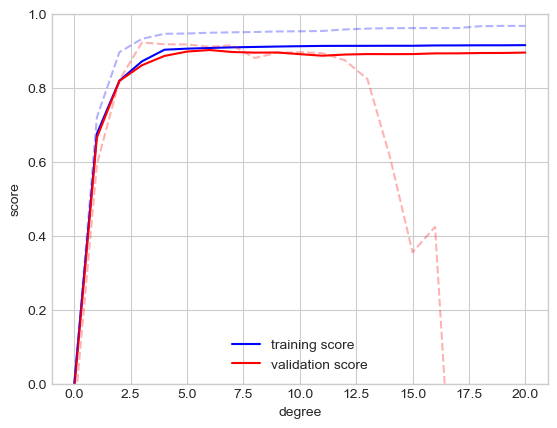

In [21]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(
                                PolynomialRegression(), X2, y2,
                                param_name='polynomialfeatures__degree',
                                param_range=degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')

plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')

plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

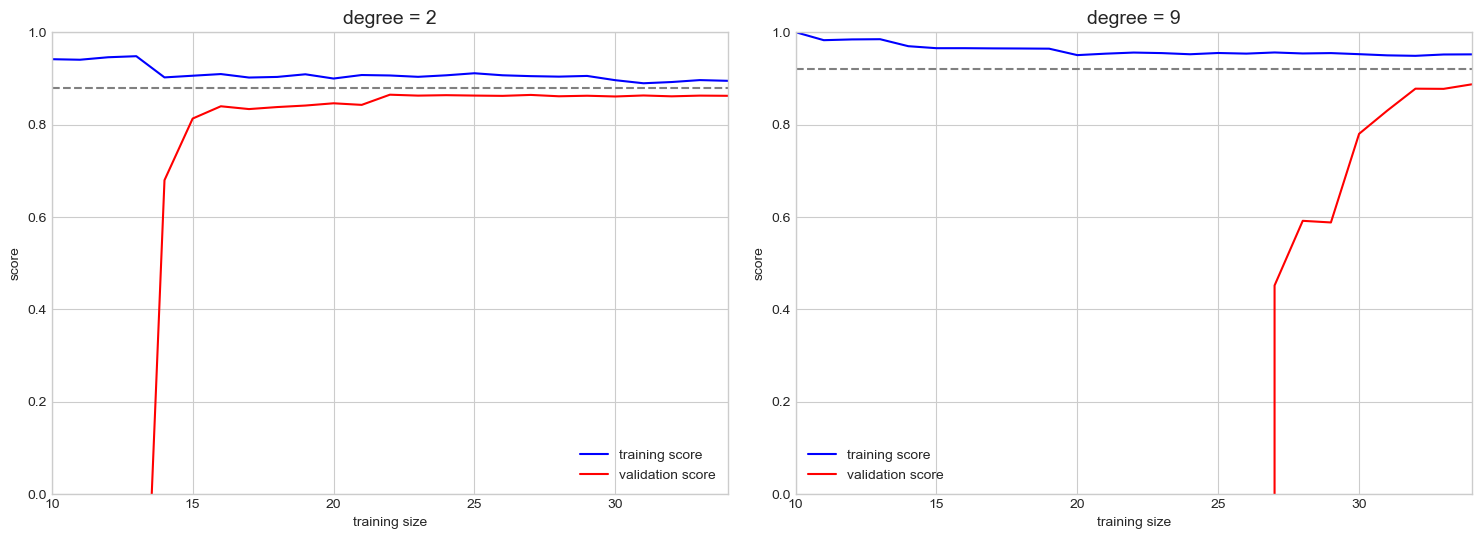

In [22]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(
                            PolynomialRegression(degree), X, y, cv=7,
                            train_sizes=np.linspace(0.3, 1, 25))
    
    ax[i].plot(N, np.mean(train_lc, 1),color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1),color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0],N[-1], color='gray', linestyle='dashed')
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

# D. Validation in Practice: Grid Search



In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

grid.fit(X, y)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__fit_intercept': [True, False],
                         'polynomialfeatures__degree': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])})

In [24]:
grid.best_params_

{'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 4}

In [25]:
model = grid.best_estimator_

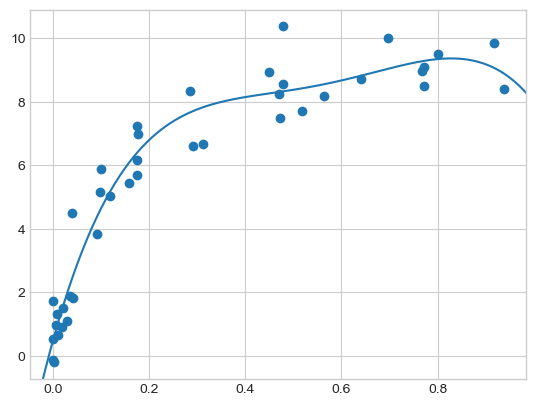

In [26]:
plt.scatter(X.ravel(), y) 
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);